# CNN for lesion classification

## 1. Brief CNN theory

A Convolutional Neural Network (CNN, or ConvNet) is a type of **feed-forward** artificial neural network in which the connectivity pattern between its neurons is inspired by the organization of the animal visual cortex.

<img src="images/convnets_cover.png" width="70%" />

> source: https://flickrcode.files.wordpress.com/2014/10/conv-net2.png

### 1.1 Structure of a CNN

> A more detailed overview of what CNNs do would be that you take the image, pass it through a series of convolutional, nonlinear, pooling (downsampling), and fully connected layers, and get an output. As we said earlier, the output can be a single class or a probability of classes that best describes the image. 

source: [1]

#### Convolutional Layer

The first layer in a CNN is always a **Convolutional Layer**.

<img src="images/same_padding_no_strides.gif" width="50%">

#### Typical CNN Structure

A traditional CNN architecture consists of other layers interspaced between convolution layers

<img src="images/Table.png">

#### Pooling layer

After some ReLu layers, **pooling layer** is typically applied.

<img src="images/MaxPool.png" width="80%"/>

Pooling reduces the amount of parameters (helping with computional efficiency) and controls overfitting

## 2. We build one using keras and tensorflow

### 2.1 Preparation

In [13]:
# setup code for this notebook
import numpy as np
import matplotlib.pyplot as plt
from functions import data, Timer
timer = Timer()

# This makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### The ultra sound scan data
- 163 scans total, clinically confirmed as having either bening or malignant (cancerous) lesions 
- 100 scans for training, 63 for testing
- Training data was passed through 7 transformations to give us 800 training images total
- We balanced the training data to have half malignant and half benign
- Since the malignant cases were less than benign cases, we use only 528 images for training
- Emperically we have found this improves our overall performance
- Testing images not transformed
- Both training and testing images were resized to 224X224
- Raw pngs then converted to numpy arrays and saved

In [14]:
# Import keras libraries
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from functions import data, Timer

In [15]:
img_rows, img_cols = 224, 224 # 224, 224 works resized down from 360, 528
color_channels = 3

if K.image_data_format() == 'channels_first':
    input_shape = (color_channels, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, color_channels)
    
print('Input shape', input_shape)

Input shape (224, 224, 3)


In [16]:
# data loader and generator helper methods
from keras.preprocessing.image import ImageDataGenerator

In [17]:
# data readers
base = "J:\\final year project\\code and models\\data\\augmented\\"
train_directory = base+'training'
validation_directory = base+'validation'

batch_size = 8

# normalization
train_generator = ImageDataGenerator(rescale=1./255)
validation_generator = ImageDataGenerator(rescale=1./255)

# this is a generator that will read scans found in
# the train directory, and indefinitely generate
# batches of image data
train_generator = train_generator.flow_from_directory(
        train_directory,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary')

# A  similar generator, for validation data
validation_generator = validation_generator.flow_from_directory(
        validation_directory,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='binary')

Found 400 images belonging to 2 classes.
Found 128 images belonging to 2 classes.


In [18]:
# Visualize
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

def visualize(model):
    model.summary()
    SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [19]:
def getModelMemoryUsage(batch_size, model):
    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return str(gbytes) + " GB" , str(gbytes*2)

### 2.2 Retraining InceptionV3 CNN

In [20]:
# We define the custom inception based model
def buildBaseModel():
    input_tensor = Input(shape=input_shape)
    base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    
    # we add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # we add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    
    #we add a logistic layer for our 2 classes
    predictions = Dense(1, activation='softmax')(x)
    
    # this is our model, a hybrid inceptionv3
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # first we train our custom top layer
    # we freeze all convolutional inceptionv3 layers
    for layer in base_model.layers:
        layer.trainable = False
        
    model.compile(optimizer='adagrad',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [21]:
model = buildBaseModel()

In [22]:
# helpers for checkpointing and early stopping
from keras.callbacks import ModelCheckpoint , EarlyStopping

def trainModel(model, epochs=5, text="Re training inception model",
              file_name='best_cnn_inc_model.h5'):
    best_model_file = file_name
    early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=True) 
    best_model = ModelCheckpoint(best_model_file, verbose=True, save_best_only=True)

    timer.start()
    network_history = model.fit_generator(
            train_generator, 
            steps_per_epoch=800,
            epochs=epochs,
            validation_data = validation_generator,
            validation_steps=256,
            verbose=True,
            callbacks=[best_model])
    timer.stop(text)
    return network_history

In [23]:
# visualize(model)
model.summary()
gpu, ram = getModelMemoryUsage(batch_size, model)
print("GPU Memory:" + gpu + "RAM:" + ram)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [24]:
history = trainModel(model, 
                     1, 
                     "Re training on our data with frozen inception layers", "5 lower.h5")

Epoch 1/1
800/800 [==============================] - 242s 302ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 7.97119, saving model to 5 lower.h5
Timing:: took 4 minutes Re training on our data with frozen inception layers
-----------------------------------


In [26]:
# building the rest of the model

# here we choose to retrain the top 2 inception blocks
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we now recompile the model for our layer modifications to take effect
from keras.optimizers import SGD
model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_2 = trainModel(model, 
                       1,
                       "Re training the full inception model",
                       '5 upper.h5')

Epoch 1/1
800/800 [==============================] - 316s 395ms/step - loss: 7.9712 - acc: 0.5000 - val_loss: 7.9712 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 7.97119, saving model to 5 upper.h5
Timing:: took 5 minutes Re training the full inception model
-----------------------------------


In [27]:
def plot(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')

### 2.3 Evaluating the CNNs performance

#### Evaluating the lower frozen CNN performance

In [28]:
# Get test data
x_test, y_test = data.getTestData()
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Test data shape:  (63, 224, 224, 3)
Test labels shape:  (63, 1)


In [29]:
X_test = x_test/255

In [30]:
# load and evaluate best model
from keras.models import load_model
best_model = load_model('5 lower.h5')
best_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [31]:
best_model.predict(x_test)

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [32]:
# Evaluate all
from sklearn.metrics import confusion_matrix
expected = y_test
prediction = best_model.predict(x_test)
x, y, fn, tp = confusion_matrix(y_test, prediction).ravel()
print(fn, tp)

0 21


The model only predicts malignant cases. This means the models performance is poor. In this case transfer learning has not been of much help because of the difference between the natural images that were used to train the Inception model and very different from breast ultrasounds but also, our dataset is not sufficiently large for newly learned features to significantly affect the hybrid models output hence the poor performance.

#### Evaluating the uppper retrained CNN performance

In [34]:
# load and evaluate best model
from keras.models import load_model
best_model = load_model('5 upper.h5')
best_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [35]:
best_model.predict(x_test)

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]], dtype=float32)

In [2]:
# load and evaluate best model
from keras.models import load_model
best_model = load_model('5 upper.h5')
best_model.summary()

p:\program files\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

In [5]:
#  load test data only
import numpy as np
from functions import data
x_test, y_test = data.getTestData()
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Test data shape:  (63, 224, 224, 3)
Test labels shape:  (63, 1)


In [7]:
# Evaluate a set of images image
limit = x_test.shape[0]
predictions = best_model.predict(x_test)

In [8]:
actual = y_test
print(actual[0])
print(predictions[0])

[0]
[1.]


In [9]:
def printMetrics(tn, fp, fn, tp):
    sensitivity = tp/(tp+fn)
    precision = tp/(tp+fp)
    specificity = tn/(fp+tn)
    f_measure = (2*tp)/((2*tp)+fp+fn)
    
    print("True Positive Rate (TPR) or Hit Rate or Recall or Sensitivity: ", sensitivity)
    print('\n')
    print("Precision: ", precision)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    print("F measure: ", f_measure)

In [11]:
# Evaluate all
from sklearn.metrics import confusion_matrix
expected = y_test
prediction = best_model.predict(x_test)
tn,fp,fn,tp = confusion_matrix(y_test, prediction).ravel()
print("false negatives: ", fn)
print("true positives: ", tp)
print("true negatives: ", tn)
print("false positives: ", fp)
printMetrics(tn, fp, fn, tp)

false negatives:  0
true positives:  21
true negatives:  0
false positives:  42
True Positive Rate (TPR) or Hit Rate or Recall or Sensitivity:  1.0


Precision:  0.3333333333333333
Sensitivity:  1.0
Specificity:  0.0
F measure:  0.5


In [12]:
from sklearn.metrics  import roc_curve, auc
import matplotlib.pyplot as plt
import random

In [13]:
actual = y_test
print(actual[0])
print(predictions[0])

[0]
[1.]


In [14]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

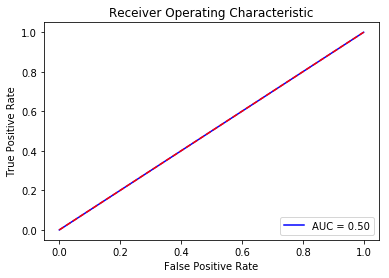

In [15]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.2])
# plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The model only predicts malignant cases. This means the models performance is poor. In this case transfer learning has not been of much help because of the difference between the natural images that were used to train the Inception model and very different from breast ultrasounds but also, our dataset is not sufficiently large for newly learned features to significantly affect the hybrid models output hence the poor performance.

### References for images and some content:

\[1\] [https://adeshpande3.github.io/adeshpande3.github.io/]() 
<br> \[2\] ["Neural Networks and Deep Learning"](http://neuralnetworksanddeeplearning.com/) by Michael Nielsen.
<br> \[3\] Deep learning with TensorFlow and Keras by Valerio Maggio